## What is Machine Translation?
Machine translation (MT) refers to fully automated software that can translate source content into target languages. Humans may use MT to help them render text and speech into another language, or the MT software may operate without human intervention.

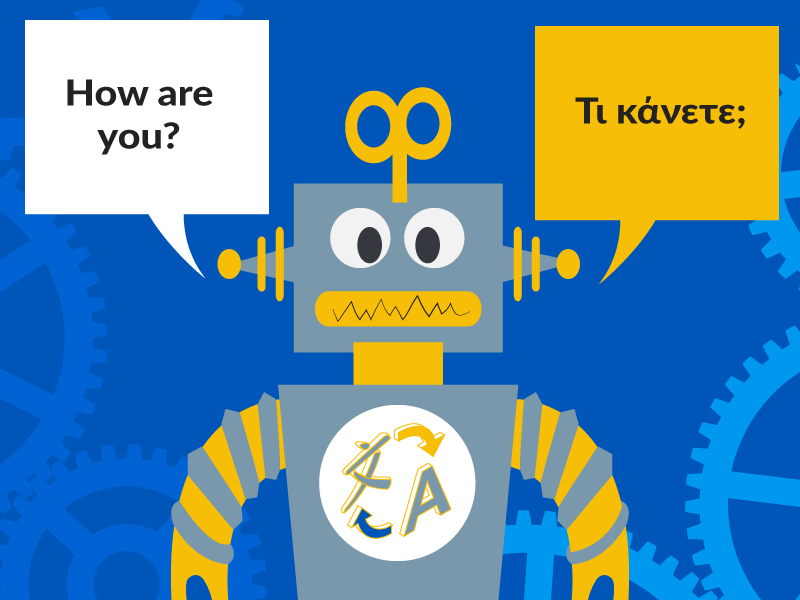

MT tools are often used to translate vast amounts of information involving millions of words that could not possibly be translated the traditional way. The quality of MT output can vary considerably; MT systems require “training” in the desired domain and language pair to increase quality.

Translation companies use MT to augment productivity of their translators, cut costs, and provide post-editing services to clients. MT use by language service providers is growing quickly. 

Source: https://www.gala-global.org/what-machine-translation

This notebook is an implementation of the article : https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

## Let's start the process of building a model which translates English to French

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM,Dense

batch_size=64
epochs=100
latent_dim=256
num_samples=10000

data_path='fra.txt'

In [5]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [6]:
input_characters=sorted(list(input_characters))
target_characters=sorted(list(target_characters))

num_encoder_tokens=len(input_characters)
num_decoder_tokens=len(target_characters)

max_encoder_seq_length=max([len(txt) for txt in input_texts])
max_decoder_seq_length=max([len(txt) for txt in target_texts])

In [7]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [8]:
input_token_index=dict(
    [(char,i) for i, char in enumerate(input_characters)])
target_token_index=dict(
[(char,i) for i, char in enumerate(target_characters)])

In [9]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

In [10]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

## Defining the encoder and decoder

In [11]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [12]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 17s 50ms/step - loss: 1.4543 - accuracy: 0.7352 - val_loss: 1.0205 - val_accuracy: 0.7182
Epoch 2/100
125/125 [==============================] - 3s 24ms/step - loss: 0.8571 - accuracy: 0.7700 - val_loss: 0.8262 - val_accuracy: 0.7702
Epoch 3/100
125/125 [==============================] - 3s 21ms/step - loss: 0.6818 - accuracy: 0.8089 - val_loss: 0.6938 - val_accuracy: 0.7991
Epoch 4/100
125/125 [==============================] - 4s 35ms/step - loss: 0.5817 - accuracy: 0.8319 - val_loss: 0.6343 - val_accuracy: 0.8122
Epoch 5/100
125/125 [==============================] - 5s 38ms/step - loss: 0.5304 - accuracy: 0.8453 - val_loss: 0.5858 - val_accuracy: 0.8286
Epoch 6/100
125/125 [==============================] - 2s 20ms/step - loss: 0.4929 - accuracy: 0.8555 - val_loss: 0.5612 - val_accuracy: 0.8356
Epoch 7/100
125/125 [==============================] - 2s 20ms/step - loss: 0.4622 - accuracy: 0.8637 - val_loss: 0.5376 - val_accuracy

In [13]:
model.save('eng2french.h5')

In [15]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


In [16]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [17]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Bouge !

-
Input sentence: Go.
Decoded sentence: Bouge !

-
Input sentence: Go.
Decoded sentence: Bouge !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: 